In [106]:
import pandas as pd
from scipy.interpolate import interp1d
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import price_data as price
import mplfinance as mpf
import matplotlib.dates as mpl_dates
import chart

crypto=price.get_price_data('1d', symbol='MATIC/USD')

# Creating Heikin Ashi candles
First we must download the candlestick data

In [107]:
crypto["Date"] = pd.to_datetime(crypto["unix"], unit="ms")
weekly_candles_original=price.get_price_data('1w',data=crypto, offset=0)
weekly_candles = weekly_candles_original.copy()
weekly_candles["Date"] = pd.to_datetime(weekly_candles["unix"], unit="ms")
weekly_candles.columns = ['Unix', 'Close', 'High', 'Low', 'Open', 'Date']
weekly_candles.set_index('Date', inplace=True)
weekly_candles_original

,unix,close,high,low,open
0,1568592000000,210.98,224.26,188.37,189.26
1,1569196800000,169.39,211.56,152.21,211.13
2,1569801600000,170.07,185.70,145.00,169.39
3,1570406400000,181.03,197.35,168.64,170.10
4,1571011200000,175.47,188.45,168.46,181.03
...,...,...,...,...,...
153,1661126400000,1426.60,1722.10,1423.60,1617.80
154,1661731200000,1578.80,1649.00,1421.90,1426.60
155,1662336000000,1766.90,1790.30,1490.10,1578.80
156,1662940800000,1334.60,1784.00,1325.50,1766.90


In [108]:
crypto

,unix,close,high,low,open,Date
0,1568419200000,188.76,189.19,180.39,181.565,2019-09-14
1,1568505600000,189.26,190.86,186.21,188.760,2019-09-15
2,1568592000000,197.70,199.39,188.37,189.260,2019-09-16
3,1568678400000,207.93,215.06,196.20,197.710,2019-09-17
4,1568764800000,210.11,217.12,207.76,207.830,2019-09-18
...,...,...,...,...,...,...
1101,1663545600000,1375.70,1393.60,1279.80,1334.800,2022-09-19
1102,1663632000000,1322.90,1385.10,1312.60,1375.700,2022-09-20
1103,1663718400000,1245.40,1410.00,1219.20,1322.900,2022-09-21
1104,1663804800000,1326.30,1349.30,1237.20,1245.400,2022-09-22


In [109]:
weekly_candles

,Unix,Close,High,Low,Open
Date,,,,,
2019-09-16,1568592000000,210.98,224.26,188.37,189.26
2019-09-23,1569196800000,169.39,211.56,152.21,211.13
2019-09-30,1569801600000,170.07,185.70,145.00,169.39
2019-10-07,1570406400000,181.03,197.35,168.64,170.10
2019-10-14,1571011200000,175.47,188.45,168.46,181.03
...,...,...,...,...,...
2022-08-22,1661126400000,1426.60,1722.10,1423.60,1617.80
2022-08-29,1661731200000,1578.80,1649.00,1421.90,1426.60
2022-09-05,1662336000000,1766.90,1790.30,1490.10,1578.80


Then we define a function to convert each candle stick into Heikin Ashi Candlestick

In [110]:
def heikin_ashi(previous_open, previous_close, candle):
    # print(candle)
    price_values = candle[["open","high","low","close"]]
    close = np.mean(price_values)
    open_price = 0.5*(previous_open+previous_close)
    high=max([max(price_values), open_price,close])
    low = min([min(price_values), open_price,close])
    
    return candle["unix"], open_price, high, close, low

def convert_data_to_heikin_ashi(data):
    timestamps, opens, closes, highs, lows  = [0], [0],[0],[0],[0]
    #initialise values
    for i in range(1,len(data)):
        timestamp, open_price, high, close, low = heikin_ashi(opens[-1], closes[-1],data.iloc[i])
        timestamps.append(timestamp)
        opens.append(open_price)
        highs.append(high)
        lows.append(low)
        closes.append(close)

    return pd.DataFrame({'unix':timestamps,'open':opens,'high':highs,'low':lows,'close':closes}).sort_values(by=['unix'], ignore_index=True)
    


Then we convert weekly candles and observe

In [111]:
weekly_candles
# convert_data_to_heikin_ashi(weekly_candles)

,Unix,Close,High,Low,Open
Date,,,,,
2019-09-16,1568592000000,210.98,224.26,188.37,189.26
2019-09-23,1569196800000,169.39,211.56,152.21,211.13
2019-09-30,1569801600000,170.07,185.70,145.00,169.39
2019-10-07,1570406400000,181.03,197.35,168.64,170.10
2019-10-14,1571011200000,175.47,188.45,168.46,181.03
...,...,...,...,...,...
2022-08-22,1661126400000,1426.60,1722.10,1423.60,1617.80
2022-08-29,1661731200000,1578.80,1649.00,1421.90,1426.60
2022-09-05,1662336000000,1766.90,1790.30,1490.10,1578.80


Shift timestamps up one, delete the top and bottom row (top row is null, bottom row is incomplete). The candle at each timestamp represents the previous week, any data we observe at time=t is from the past.

In [112]:
def convert_data_to_heikin_ashi_processed(data):
    timestamps, opens, closes, highs, lows  = [0], [0],[0],[0],[0]
    #initialise values
    for i in range(1,len(data)):
        timestamp, open_price, high, close, low = heikin_ashi(opens[-1], closes[-1],data.iloc[i])
        timestamps.append(timestamp)
        opens.append(open_price)
        highs.append(high)
        lows.append(low)
        closes.append(close)

    candles = pd.DataFrame({'unix':timestamps,'ha_Open':opens,'ha_High':highs,'ha_Low':lows,'ha_Close':closes}).sort_values(by=['unix'], ignore_index=True)
    timestamp_df=candles['unix'].shift(periods=-1)
    candles["unix"] = timestamp_df
    candles["Date"] = pd.to_datetime(candles["unix"], unit="ms")
    candles["Green"] = candles["ha_Close"]>candles["ha_Open"]
    candles.drop([0,1,len(candles)-1], inplace=True)
    candles.set_index("Date", inplace=True)
    candles.drop("unix", axis=1, inplace=True)
    return candles

heikin_ashi_candles = convert_data_to_heikin_ashi_processed(weekly_candles_original)
# weekly_candles.to_csv('weekly.csv')
# heikin_ashi_candles.to_csv('weekly_ha.csv')
heikin_ashi_candles


,ha_Open,ha_High,ha_Low,ha_Close,Green
Date,,,,,
2019-10-07,93.036250,185.700000,93.036250,167.5400,True
2019-10-14,130.288125,197.350000,130.288125,179.2800,True
2019-10-21,154.784062,188.450000,154.784062,178.3525,True
2019-10-28,166.568281,191.750000,152.960000,176.1000,True
2019-11-04,171.334141,193.080000,171.334141,183.9450,True
...,...,...,...,...,...
2022-08-22,1701.985344,2012.900000,1523.400000,1772.5000,True
2022-08-29,1737.242672,1737.242672,1423.600000,1547.5250,False
2022-09-05,1642.383836,1649.000000,1421.900000,1519.0750,False


Now we plot the heikin ashi candles using the mpfinance module.

In [113]:
# weekly_candles.drop(labels=["unix"], inplace=True)
# heikin_ashi_candles.drop(labels=["unix"], inplace=True)
# heikin_ashi_candles=heikin_ashi_candles.drop(["unix"], axis=1)
trimmed_weekly=weekly_candles[3:]
combnined_df=pd.concat([trimmed_weekly, heikin_ashi_candles], axis=1)
testing_df_weekly = combnined_df.loc[:,["Open", "Green"]]
testing_df_weekly

,Open,Green
Date,,
2019-10-07,170.10,True
2019-10-14,181.03,True
2019-10-21,175.47,True
2019-10-28,184.27,True
2019-11-04,181.55,True
...,...,...
2022-08-22,1617.80,True
2022-08-29,1426.60,False
2022-09-05,1578.80,False


Note: We will assess action on the close of the heikin ashi candle, say timestamp t, at which the current price will be the open of the normal candle at timestamp t.

In [114]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Candlestick(x=heikin_ashi_candles.index,
                open=heikin_ashi_candles['ha_Open'],
                high=heikin_ashi_candles['ha_High'],
                low=heikin_ashi_candles['ha_Low'],
                close=heikin_ashi_candles['ha_Close'])])

fig2 = go.Figure(data=[go.Candlestick(x=trimmed_weekly.index,
                open=trimmed_weekly['Open'],
                high=trimmed_weekly['High'],
                low=trimmed_weekly['Low'],
                close=trimmed_weekly['Close'])])

# fig.update_yaxes(type="log")
# fig2.update_yaxes(type="log")
fig.show()
fig2.show()


For each candle calculate the following metrics:
-  Close/low
-  close/high
-  close/open

In [115]:
# closes = np.array(heikin_ashi_candles["Close"])
# open_prices = np.array(heikin_ashi_candles["Open"])
# highs = np.array(heikin_ashi_candles["High"])
# lows = np.array(heikin_ashi_candles["Low"])

# c_l = np.divide(closes,lows)
# c_h = np.divide(closes, highs)
# c_o = np.divide(closes, open_prices)

### Backtesting
Now that we have matched the heikin ashi candles to the normal candles, we can backtest a simple trading strategy that sells when the HA candle is red and buys when it's green.

In [116]:
def single_test(raw_data: pd.DataFrame, sample_size=None):
    normal_candles = raw_data.__copy__()
    ha = convert_data_to_heikin_ashi_processed(raw_data)
    normal_candles["Date"] = pd.to_datetime(normal_candles["unix"], unit="ms")
    normal_candles.columns = ['Unix', 'Close', 'High', 'Low', 'Open', 'Date']
    normal_candles.set_index('Date', inplace=True)
    combined_data=pd.concat([normal_candles, ha], axis=1).dropna()
    test_df = combined_data.loc[:,["Open", "Green"]]
    if sample_size !=None:
        test_df = test_df.iloc[len(test_df)-sample_size-1:]
    

    longs, shorts, outcome, profit, final_equity, equity_curve=backtest_heikin_ashi(test_df)
    fig = go.Figure(data=[go.Candlestick(x=combined_data.index,
                    open=combined_data['Open'],
                    high=combined_data['High'],
                    low=combined_data['Low'],
                    close=combined_data['Close'])])
    
    fig2 = go.Figure(data=[go.Candlestick(x=combined_data.index,
                    open=combined_data['ha_Open'],
                    high=combined_data['ha_High'],
                    low=combined_data['ha_Low'],
                    close=combined_data['ha_Close'])])
    # plt.vlines(longs, ymin=raw_data['low'].min(), ymax=raw_data['high'].max(), colors='green')
    # plt.vlines(shorts, ymin=raw_data['low'].min(), ymax=raw_data['high'].max(), colors='red')
    return longs, shorts, outcome, profit, final_equity, equity_curve, fig, fig2

def single_test_lower_timeframe(raw_data: pd.DataFrame, no_consecutive, sample_size=None):
    normal_candles = raw_data.__copy__()
    ha = convert_data_to_heikin_ashi_processed(raw_data)
    normal_candles["Date"] = pd.to_datetime(normal_candles["unix"], unit="ms")
    normal_candles.columns = ['Unix', 'Close', 'High', 'Low', 'Open', 'Date']
    normal_candles.set_index('Date', inplace=True)
    combined_data=pd.concat([normal_candles, ha], axis=1).dropna()
    test_df = combined_data.loc[:,["Open", "Green"]]
    if sample_size !=None:
        test_df = test_df.iloc[len(test_df)-sample_size-1:]
    
    longs, shorts, outcome, profit, final_equity, equity_curve=backtest_heikin_ashi_lower_timeframe(test_df, no_consecutive)
    fig = go.Figure(data=[go.Candlestick(x=combined_data.index,
                    open=combined_data['Open'],
                    high=combined_data['High'],
                    low=combined_data['Low'],
                    close=combined_data['Close'])])
    
    fig2 = go.Figure(data=[go.Candlestick(x=combined_data.index,
                    open=combined_data['ha_Open'],
                    high=combined_data['ha_High'],
                    low=combined_data['ha_Low'],
                    close=combined_data['ha_Close'])])
    # plt.vlines(longs, ymin=raw_data['low'].min(), ymax=raw_data['high'].max(), colors='green')
    # plt.vlines(shorts, ymin=raw_data['low'].min(), ymax=raw_data['high'].max(), colors='red')
    print(np.sum(outcome)/len(outcome))
    print(np.mean(profit))
    print(final_equity)
    return longs, shorts, outcome, profit, final_equity, equity_curve, fig, fig2

    

def backtest_heikin_ashi(test_df): # raw data contains normal OHCL candles
    equity=1
    fee_rate=0.0006
    state='neutral'
    timestamps = test_df.index.date
    equity_record=[]
    longs=[]
    shorts=[]
    outcome=[]
    profit=[]
    sl=None
    entry=None
    equity_curve=[]
    print('Datapoints: ',len(test_df))
    for i in range(1,len(test_df)):

        time=timestamps[i]
        
        current=test_df.iloc[i]['Open'].item() # uses opens now as opens are confirmed
        green= test_df.iloc[i]["Green"]
        
        if green and state != 'long':
            #remember to calculate profit if flipping from short
            if state=='short':
                outcome.append(current<entry)
                profit.append(1-(current/entry))
                equity=equity*(1+(1-(current/entry))-fee_rate)
                # equity=(entry*trade_amount-current*trade_amount)+equity
            entry=current
            equity_curve.append([time,equity])
            state='long'
            longs.append(time)
        elif not(green) and state != 'short':
            if state=='long':
                outcome.append(current>entry)
                profit.append(current/entry -1)
                equity=equity*(1+(current/entry -1)-fee_rate)
            entry=current
            equity_curve.append([time,equity])    
            # trade_amount=equity*entry
            state='short'
            shorts.append(time)
            #print(state+' from $'+str(current))
        if equity < 0.05:
            equity=0
            print('went broke')
            break

        if i==len(test_df)-1:
            if state=='long':
                equity=equity*(current/entry)
            elif state=='short':
                equity=equity*(2-current/entry)
            equity_curve.append([time,equity])

    
    return longs,shorts,np.array(outcome), np.array(profit), equity, np.array(equity_curve)

def backtest_heikin_ashi_lower_timeframe(test_df, no_consecutive): # raw data contains normal OHCL candles
    equity=1
    fee_rate=0.0006
    state='neutral'
    timestamps = test_df.index.date
    equity_record=[]
    longs=[]
    shorts=[]
    outcome=[]
    profit=[]
    sl=None
    entry=None
    equity_curve=[]
    print('Datapoints: ',len(test_df))
    for i in range(1,len(test_df)):

        time=timestamps[i]
        
        current=test_df.iloc[i]['Open'].item() # uses opens now as opens are confirmed
        green= test_df.iloc[i-no_consecutive:i+1]["Green"].all()
        
        if green and state != 'long':
            #remember to calculate profit if flipping from short
            if state=='short':
                outcome.append(current<entry)
                profit.append(1-(current/entry))
                equity=equity*(1+(1-(current/entry))-fee_rate)
                # equity=(entry*trade_amount-current*trade_amount)+equity
            entry=current
            equity_curve.append([time,equity])
            state='long'
            longs.append(time)
        elif not(green) and state != 'short':
            if state=='long':
                outcome.append(current>entry)
                profit.append(current/entry -1)
                equity=equity*(1+(current/entry -1)-fee_rate)
            entry=current
            equity_curve.append([time,equity])    
            # trade_amount=equity*entry
            state='short'
            shorts.append(time)
            #print(state+' from $'+str(current))
        if equity < 0.05:
            equity=0
            print('went broke')
            break

        if i==len(test_df)-1:
            if state=='long':
                equity=equity*(current/entry)
            elif state=='short':
                equity=equity*(2-current/entry)
            equity_curve.append([time,equity])

    
    return longs,shorts,np.array(outcome), np.array(profit), equity, np.array(equity_curve)

In [117]:
result = []
for i in range(7):
    weekly_candles_offset=price.get_price_data('1w',data=crypto, offset=i)
    longs, shorts, outcome, profit, final_equity, equity_curve, fig, fig2 = single_test(weekly_candles_offset)
    # fig.add_vline(x=longs[0], line_width=3, line_dash="dash", line_color="green")
    result.append((i,final_equity))
fig.show()
fig2.show()
result

Datapoints:  155
Datapoints:  155
Datapoints:  155
Datapoints:  155
Datapoints:  155
Datapoints:  155
Datapoints:  155


[(0, 3.9798426860962155),
 (1, 11.503463180334128),
 (2, 21.1821500468291),
 (3, 22.06738877662046),
 (4, 11.492588865355833),
 (5, 13.237586320527331),
 (6, 7.877609484491442)]

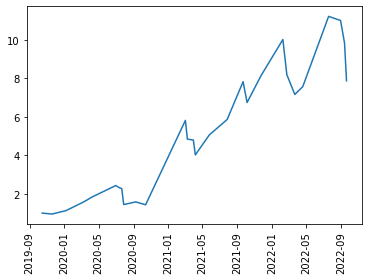

In [118]:
plt.plot(equity_curve[:,0], equity_curve[:,1])

plt.tick_params(axis='x',labelsize=10,rotation=90)